# Quantum Fisher information

> Computation of the quantum Fisher information of parameterized quantum states showcasing the functionalities of the developped package. 

The quantum Fisher information (QFI) is a metric that quantifies the contribution of the parameters to the representability of a parameterized quantum state $\psi(\theta)$. In a sense, the QFI characterizes the distinguishability between quantum states in parameter space. It is a key quantity in many fields of quantum physics. For instance, in quantum metrology, the QFI bounds the accuracy with which we can infer the value of the parameters characterizing a given state. The QFI can also be used as multipartite entanglement witness for quantum information processing tasks, for instance. In a completely different case, it is used to enhance optimization algorithms leveraging the information it provides about the curvature of the parameter space.     

However, despite the broad applicability of the QFI, it is not directly related to any kind of physical observable, making it a rather elusive quantity that is usually quite computationally costly to obtain. Here, we illustrate how to use our package to compute the quantum Fisher information matrix with two approximate algorithms: the parameter shift rule and the method introduced in [[1]](https://arxiv.org/pdf/2104.00519.pdf), which we then compare with the [existing methods from the qiskit library](https://qiskit.org/documentation/tutorials/operators/02_gradients_framework.html#Quantum-Fisher-Information-(QFI)). 

In [ ]:
#hide
import numpy as np
from scipy.optimize import curve_fit

from qiskit import QuantumCircuit
from qiskit.opflow import CircuitStateFn
from qiskit.circuit import ParameterVector
from qiskit.providers.aer import QasmSimulator

from functools import partial
from fisherman.overlap.all import *
from fisherman.utils import sym_from_triu

import matplotlib.pyplot as plt

## QFI from parameter shift-rule

The elements of the QFI matrix of a parameterized state $\psi(\boldsymbol{\theta})$ are defined by 

$$\mathcal{F}_{i j}=4 \operatorname{Re}\left[\left\langle\partial_{i} \psi(\boldsymbol{\theta}) \mid \partial_{j} \psi(\boldsymbol{\theta})\right\rangle -\left\langle\partial_{i} \psi(\boldsymbol{\theta}) \mid \psi(\boldsymbol{\theta})\right\rangle\left\langle\psi(\boldsymbol{\theta}) \mid \partial_{j} \psi(\boldsymbol{\theta})\right\rangle\right],$$ 

where $\partial_{i}\psi(\boldsymbol{\theta})$ denotes the partial derivative of the state $\psi(\boldsymbol{\theta})$ with respect to the parameter $\theta_i$. The gradients may be computed via the parameter shift-rule, effectively obtaining the elements of the QFI matrix as 

$$\mathcal{F}_{i j}=-\frac{1}{2} \left(\left|\left\langle\psi(\boldsymbol{\theta}) \mid \psi\left(\boldsymbol{\theta}+\left(\boldsymbol{e}_{i}+\boldsymbol{e}_{j}\right) \frac{\pi}{2}\right)\right\rangle\right|^{2}\right.
-\left|\left\langle\psi(\boldsymbol{\theta}) \mid \psi\left(\boldsymbol{\theta}+\left(\boldsymbol{e}_{i}-\boldsymbol{e}_{j}\right) \frac{\pi}{2}\right)\right\rangle\right|^{2}-\left|\left\langle\psi(\boldsymbol{\theta}) \mid \psi\left(\boldsymbol{\theta}-\left(\boldsymbol{e}_{i}-\boldsymbol{e}_{j}\right) \frac{\pi}{2}\right)\right\rangle\right|^{2} 
\left.+\left|\left\langle\psi(\boldsymbol{\theta}) \mid \psi\left(\boldsymbol{\theta}-\left(\boldsymbol{e}_{i}+\boldsymbol{e}_{j}\right) \frac{\pi}{2}\right)\right\rangle\right|^{2}\right).$$

Therefore, the method to obtain the the QFI matrix reduces to the computation of a series of fidelities between states under different parameterizations. Such fidelities may be obtained through any algorithm, usually via swap tests or compute-uncompute circuits. Nevertheless, we also have implemented the method based on randomized measurements with both local and global unitaries, which we can use for the task.  

See [[2]](https://arxiv.org/abs/2103.15191) for a nice review on QFI and the described methods. 

### State and parameter definition

We will start by defining a parameterized state that depends on three parameters $\boldsymbol{\theta} = [\theta_0, \theta_1, \theta_2]^T$. We will prepare a GHZ state and add a rotation around the _x_ axis on every qubit, similar to the state prepared in [[1]](https://arxiv.org/pdf/2104.00519.pdf) (see Fig. 2).

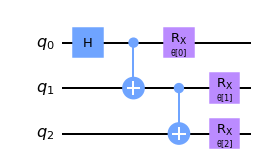

In [ ]:
n_qubits = 3

theta = ParameterVector('θ', 3)
param_values = np.zeros(n_qubits) # arbitrary parameter assignment
qc = QuantumCircuit(n_qubits)
qc.h(0)
for i in range(n_qubits-1): qc.cx(i, i+1)
for i in range(n_qubits): qc.rx(theta[i], i)
qc.draw('mpl')

> Note: This circuit has been chosen to illustrate the process with an intuitive and simple example that we can relate to [[1]](https://arxiv.org/pdf/2104.00519.pdf). We encourage everyone to try out more complex circuits in terms of the QFI determination. For instance, implementing the rotations before or between the entangling `cx` gates. It is also worth noting that the QFI may change as function of the parameter value, so we also encourage you to try out with different values of $\theta$ (it is now zero).

### QFI computation

Given that the QFI matrix is symmetric, we only need to care about the computation of the upper or lower triangular parts. To keep the code simple and understandable, we will consider four shifts: one per term on the sum. This way, we will call our overlap function four times, every time obtaining the upper triangular values of the QFI that correspond to their respecitve elements in the sum.

We will define our own function to obtain the QFI matrix that accepts an `overlap` callable, which can be any of the `fisherman.overlap` functions. These heavily simplify the code, allowing us to freely experiment and focus on the applications. 

In [ ]:
def qfi_parameter_shift(state, param_values, overlap):
    "Computes the quantum Fisher information matrix through parameter-shift rule."
    n_params = len(param_values)
    e = np.eye(n_params)
    plus_shift  = np.array([(e_i + e_j)*np.pi/2 for i, e_i in enumerate(e) for e_j in e[i:]])
    minus_shift = np.array([(e_i - e_j)*np.pi/2 for i, e_i in enumerate(e) for e_j in e[i:]])

    dict_zero        = dict(zip(theta, param_values))
    dict_plus_plus   = dict(zip(theta, (param_values + plus_shift ).T.tolist()))
    dict_plus_minus  = dict(zip(theta, (param_values + minus_shift).T.tolist()))
    dict_minus_minus = dict(zip(theta, (param_values - minus_shift).T.tolist()))
    dict_minus_plus  = dict(zip(theta, (param_values - plus_shift ).T.tolist()))
    dicts = [dict_plus_plus, dict_plus_minus, dict_minus_minus, dict_minus_plus]
    factors = np.array([1, -1, -1, 1])
    
    state0 = state.bind_parameters(dict_zero)
    terms = [f*overlap(state0, state.bind_parameters(d)) for f, d in zip(factors, dicts)]
    return sym_from_triu(-np.array(terms).sum(0)/2, n_params)

We first need to transform our circuit into a `StateFn`

In [ ]:
state = CircuitStateFn(qc)

Let's see what we get!

In [ ]:
qfi_parameter_shift(state, param_values, compute_uncompute_overlap)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
qfi_parameter_shift(state, param_values, swap_test_overlap)

array([[ 1.00097656, -0.02441406, -0.07324219],
       [-0.02441406,  1.00390625,  0.05273438],
       [-0.07324219,  0.05273438,  1.01660156]])

In [ ]:
qfi_parameter_shift(state, param_values, randomized_measurement_overlap)

array([[ 1.1200881 ,  0.05162481,  0.00822033],
       [ 0.05162481,  1.09190233, -0.01296078],
       [ 0.00822033, -0.01296078,  0.97356309]])

We see very nice agreement betweeen all the methods. The compute-uncompute is the most accurate one as the QFI is, indeed, the identity in this case. This means that we can fully determine all the parameters from our measurements and that they are independent from each other. 

In case that we want to try a different backend or, simply, other options of the overlap functions, we can define a partial. For instance, we can increase the number of random unitary measurements performed in the last method to improve the performance and use global unitary operators instead of local ones.

In [ ]:
rnd_overlap = partial(randomized_measurement_overlap, n_rnd=300, local=False)
qfi_parameter_shift(state, param_values, rnd_overlap)

array([[1.03706235, 0.01959682, 0.00622802],
       [0.01959682, 0.99992238, 0.02136687],
       [0.00622802, 0.02136687, 0.99086517]])

We can use the `QFI` converter from qiskit to compare and validate our results. 

In [ ]:
from qiskit.opflow.gradients import QFI

In [ ]:
qfi_lin_comb = QFI().convert(state, theta)
qfi_lin_comb.assign_parameters(dict(zip(theta, param_values))).eval()

array([[1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j]])

However, this converter works exclusively for pure states, while our `fisherman` functions support noisy backends that produce mixed states, as shown in detail in the device-independent certification example. We can try obtaining the QFI matrix from the same circuit run in a (simulated) quantum computer with depolarizing noise. 

In [ ]:
from qiskit.test.mock import FakeVigo

In [ ]:
# backend = QasmSimulator.from_backend(FakeVigo())
# rnd_overlap = partial(randomized_measurement_overlap, n_rnd=300, backend=backend)
# qfi_parameter_shift(state, param_values, rnd_overlap)

array([[0.60855002, 0.01598284, 0.01513812],
       [0.01598284, 0.67006369, 0.02558377],
       [0.01513812, 0.02558377, 0.68090349]])

## Sub-QFI

Following the same case of study, we now implement an entirely different approach to compute the QFI as introduced in [[1]](https://arxiv.org/pdf/2104.00519.pdf). The proposed method provides the so-called "sub-QFI" [[3]](https://iopscience.iop.org/article/10.1088/2058-9565/abfbef/meta), which is a lower bound to the QFI. As previously mentioned, the QFI quantifies the distance between states in parameter space, which allows us to determine how sensitive is a state $\rho_\theta$ to small perturbations $d\theta$ in its parameters. This is, indeed, related with the curvature of the fidelity $F\left(\rho_\theta,\rho_{\theta+d\theta}\right)$ as, the larger the curvature ($\propto dF/d\theta^2$), the higher the sensibility to changes in $\theta$ and, thus, the larger the QFI. 

Intuitively, the higher the distance between $\rho_\theta$ and $\rho_{\theta+d\theta}$ the more information can be extracted to determine the unknown parameter $\theta$ through measurements, which is the QFI. Actually, the QFI associated to the parameter $\theta$ can be expressed in terms of the second derivative of the previous fidelity 

$$\mathcal{F}_\theta(\rho_\theta) = 8\lim_{d\theta\to 0}\frac{1-F(\rho_\theta,\rho_{\theta+d\theta})}{d\theta^2}.$$

Nevertheless, the fidelity is very costly to obtain so we approximate it by the super-fidelity $G$, whose square root provides an upper bound, and can be entirely computed in terms of state overlaps of the form $\text{Tr}\left[\rho_0\rho_1\right]$. The sub QFI is then 

$$\mathcal{f}_\theta(\rho_\theta) \simeq 8\frac{1 - \sqrt{G(\rho_\theta, \rho_{\theta+d\theta})}}{d\theta^2},$$
$$G(\rho_0,\rho_1)=\text{Tr}\left[\rho_0\rho_1\right] + \sqrt{\left(1-\text{Tr}\left[\rho_0^2\right]\right)\left(1-\text{Tr}\left[\rho_1^2\right]\right)}.$$

Notice that, for pure states, the super-fidelity becomes the fidelity and, therefore, we obtain the actual QFI.

Hence, the methodology introduced in [[1]](https://arxiv.org/pdf/2104.00519.pdf) consists on approximating the Bures distance $\mathcal{D}(\theta)=8\left(1 - \sqrt{G(\rho_\theta, \rho_{\theta+d\theta})}\right)$ by its second order Taylor expansion around $\theta$, such that $\mathcal{D}(\theta)\simeq\mathcal{f}_\theta(\rho_\theta)d\theta^2$. This way, we infer the sub-QFI $\mathcal{f}_\theta(\rho_\theta)$ by performing a quadratic fit to the Bures distance around $\theta$.

Let us apply this method to the circuit at hand. The main drawback of this method is that it has been developed for states characterized by a single parameter. Therefore, the Taylor expansion, as derived, is not suitable to compute crossed second derivative terms such as $\partial_i\partial_j\mathcal{D}(\theta)$ with $i\neq j$. However, we can use the approach to compute the diagonal terms of the QFI matrix involving $\partial_i^2\mathcal{D}(\theta)$, wich suffices for our current example.   

Like before, let us define a function that will ease the experimentation.

In [ ]:
def bures(x, f): return f*x**2

def sub_qfi(state, param_values, overlap, d_theta=None, return_distances=False):
    "Computes the sub quantum Fisher information matrix from the super-fidelity."
    n_params = len(param_values)
    e = np.eye(n_params)
    d_theta = np.round(np.arange(-0.4, 0.5, 0.1), 2) if d_theta is None else d_theta
    idx0 = len(d_theta)//2
    sub_qfi = np.zeros((n_params, n_params))
    dists = np.zeros((n_params, len(d_theta)))

    for i, e_i in enumerate(e):
        values = param_values[:, None] + (e_i[:, None] @ d_theta[None, :]) # Shift i-th parameter
        param_dict = dict(zip(theta, values.tolist()))
        overlaps = overlap(state, param_dict=param_dict)
        
        if np.max(overlaps) > 1: overlaps = overlaps/np.max(overlaps) # numerical stability
        super_fidelity = overlaps[idx0] + np.sqrt((1-overlaps[idx0, idx0])*(1-overlaps.diagonal()))
        bures_distance = 8*(1 - np.sqrt(super_fidelity))
        est_qfi, _ = curve_fit(bures, d_theta, bures_distance)
        sub_qfi[i, i] = est_qfi
        dists[i] = bures_distance
        
    if return_distances:
        return sub_qfi, dists
    else:
        return sub_qfi

Let's see what we get!

In [ ]:
sub_qfi(state, param_values, compute_uncompute_overlap)

array([[0.99712572, 0.        , 0.        ],
       [0.        , 0.99712572, 0.        ],
       [0.        , 0.        , 0.99712572]])

In [ ]:
sub_qfi(state, param_values, swap_test_overlap)

array([[1.01684152, 0.        , 0.        ],
       [0.        , 0.9905152 , 0.        ],
       [0.        , 0.        , 0.9490148 ]])

In [ ]:
rnd_overlap = partial(randomized_measurement_overlap, n_rnd=300)
sub_qfi(state, param_values, rnd_overlap)

array([[1.02512271, 0.        , 0.        ],
       [0.        , 1.12901337, 0.        ],
       [0.        , 0.        , 0.9984681 ]])

Since this method only computes the diagonal elements, it may seem that we are obtaining better results than with the parameter shift-rule, but it is only because the actual QFI is the identity. In contrast, if the QFI matrix had off-diagonal terms, this method would entirely fail to estimate them, as it requires further theoretical development. 

Besides, we are currently dealing with pure states. Let's see what happens with a bit of noise!

In [ ]:
# backend = QasmSimulator.from_backend(FakeVigo())
# rnd_overlap = partial(randomized_measurement_overlap, n_rnd=300, backend=backend)
# sub_qfi(state, param_values, rnd_overlap)

array([[0.83480498, 0.        , 0.        ],
       [0.        , 0.88432182, 0.        ],
       [0.        , 0.        , 0.89936983]])

We see that this approach, even though it provides a lower bound to the QFI, actually returns a larger estimation of the QFI than the parameter shift-rule in the same noisy backend. This may be due to the fact that the parameter shift-rule is built assuming that the states are pure. 

### Local curvature

A very interesting feature of this method is that it revolves around the relationship between the QFI and the local curvature of a given function. This is a key concept that is exploited in some optimization methods such as the quantum natural gradient [[4]](https://quantum-journal.org/papers/q-2020-05-25-269/). 

Let's set `return_distances=True` and estimate the QFI information matrix of a different circuit. 

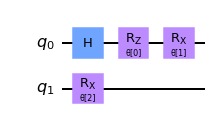

In [ ]:
n_qubits = 2
theta = ParameterVector('θ', 3)
qc = QuantumCircuit(n_qubits)
qc.h(0)
qc.rz(theta[0], 0)
qc.rx(theta[1], 0)
qc.rx(theta[2], 1)

state = CircuitStateFn(qc)

qc.draw('mpl')

In the previous one, we had that the curvature around all the parameters was the same, provided that they all had the same QFI value and the matrix was diagonal. Furhtermore, it was entirely independent of the parameter value (you would know if you had tested it :P). In this circuit, however, the curvature in each direction is different and, even more, it depends on the actual value of the parameters.  

Let's start by initializing the parameters to zero. 

In [ ]:
param_values_0 = np.zeros(3)
qfi, distances = sub_qfi(state, param_values_0, compute_uncompute_overlap, return_distances=True)
np.round(qfi, 3)

array([[ 0.997,  0.   ,  0.   ],
       [ 0.   , -0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.997]])

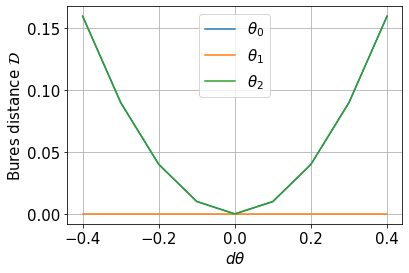

In [ ]:
#collapse_input
d_theta = np.round(np.arange(-0.4, 0.5, 0.1), 2)
plt.figure(figsize=(6, 4))
for i, dist in enumerate(distances): plt.plot(d_theta, dist, label=fr'$\theta_{i}$')
plt.legend(fontsize=15)
plt.grid()
plt.tick_params(labelsize=15)
plt.xlabel(r"$d\theta$", fontsize=15)
plt.ylabel(r"Bures distance $\mathcal{D}$", fontsize=15);

In contrast to what we observed in the first circuit, there is a parameter with null QFI. This means that we cannot extract any kind of information about it with the current configuration or, in other words, variations in the parameter have no effect on the state. Notice that the curvature of the Bures distance with respect to $\theta_1$ is very flat, suggesting that we either must perform large changes in the parameter to observe an effect in the state, or that we will never observe any effect on the state by just changing such parameter. Let's see what happens.

In [ ]:
param_values_1 = np.array([0., 1.1*np.pi/2, 0.]) # Change θ_1
qfi = sub_qfi(state, param_values_1, compute_uncompute_overlap)
np.round(qfi, 3)

array([[0.997, 0.   , 0.   ],
       [0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.997]])

Indeed we do not observe any kind of change by exclusively shifting $\theta_1$. This process is analogous to a common phenomenon in optimization processes with overparameterized anstaze in which many parameters end up in a flat region of the target function. 

In contrast, a slight change in either $\theta_0$ or $\theta_2$ may incur large changes in the value of the function.

In [ ]:
param_values_2 = np.array([0.5, 0., 0.])
qfi, distances = sub_qfi(state, param_values_2, compute_uncompute_overlap, return_distances=True)
np.round(qfi, 3)

array([[0.997, 0.   , 0.   ],
       [0.   , 0.228, 0.   ],
       [0.   , 0.   , 0.997]])

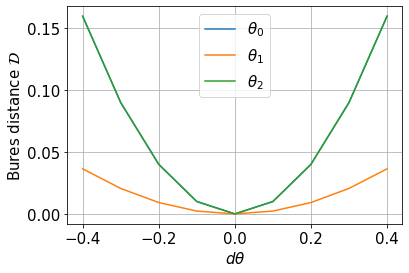

In [ ]:
#collapse_input
plt.figure(figsize=(6, 4))
for i, dist in enumerate(distances): plt.plot(d_theta, dist, label=fr'$\theta_{i}$')
plt.legend(fontsize=15)
plt.grid()
plt.tick_params(labelsize=15)
plt.xlabel(r"$d\theta$", fontsize=15)
plt.ylabel(r"Bures distance $\mathcal{D}$", fontsize=15);

Changing the value of the other parameters, we encounter a region in which the landscape around $\theta_1$ is no longer flat. Actually, while $\theta_0$ and $\theta_2$ may both have a large impact in the state, it is only $\theta_0$ that is capable of pushing $\theta_1$ outside of the flat region to where we can start obtaining information about it through measurements. This is because after applying the Hadamard gate to our first qubit, we obtain the $|+\rangle=\left(|0\rangle + |1\rangle\right)/\sqrt{2}$ state, which is an eigenvalue of $x$. Hence, unless we first apply a rotation around $z$ ($\theta_0\neq 0$), we won't be able to change the state by applying rotations around $x$ ($\theta_1$) as they only provide a global phase.

## References

[1] M. Yu _et al_. <a href="https://arxiv.org/abs/2104.00519"> Experimental estimation of the quantum Fisher information from randomized measurements<a/>. arXiv:2104.0519 (2021).
    
[2] J. J. Meyer, <a href="https://arxiv.org/abs/2103.15191">Fisher Information in Noisy Intermediate-Scale Quantum Applications <a/>. arXiv:2103.15191 (2021)
    
[3] M. Cerezo _et al_., <a href="https://iopscience.iop.org/article/10.1088/2058-9565/abfbef/meta"> Sub-quantum Fisher information<a/> _QST_ (2021)
    
[4] J. Stokes _et al_., <a href="https://quantum-journal.org/papers/q-2020-05-25-269/"> Quantum natural gradient <a/>. _Quantum_ 4, 269 (2020).